### Run these first!

In [ ]:
install.packages("tidymodels")
install.packages("vtable")
install.packages("polycor")

In [77]:
library(tidyverse)
library(repr)
library(tidymodels)
library(vtable)
library(polycor)

##Introduction

Heart disease is typically diagnosed through an angiogram, an xray that looks at the heart, major arteries and blood vessels. An angiogram is expensive, ranging from 675 CAD - 2200 CAD. What if there was an easier and less costly way to diagnose heart disease?

In this project we look at attributes derived from a simple routine checkup and blood test: blood pressure, cholesterol levels, and age, to diagnose heart disease. Specifically, we ask: Can we use blood pressure, cholesterol level, and age to determine if a patient has heart disease?

The dataset used looks at 76 different attributes, 14 of which were used by researchers for data analysis. These vary from identifiers like age or sex to max heart rate to fasting blood sugar levels. Additionally they used datasets from 4 different locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. In our analysis we combined the Cleveland and Hungary datasets. 


##Methods

The variables of importance for our analysis were age, resting blood pressure, and cholesterol levels, as they are cheaper ways to diagnose heart disease. 

We will display the correlations between our variables and heart disease through tables and scatterplots. It's important to use correlated variables because if variable x is correlated to variable y, it's very likely for there to be more variable y if we have lots of variable x.

##Preliminary exploratory data analysis 

---



In [82]:
set.seed(900)

#reads the raw data sets and converts them into tibbles with no column names
cleveland_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.cleveland.data', col_names = FALSE) |> as_tibble()
hungarian_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.hungarian.data', col_names = FALSE) |> as_tibble()

#combines the two data sets into one
heart_data <- rbind(cleveland_data, hungarian_data)

#assigns names to the columns based on information from the website
colnames(heart_data) <- c('age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'max_hr', 
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num') 

#converts all categorical attributes into factors
heart_data <- mutate(heart_data, sex = as.factor(sex), chest_pain = as.factor(chest_pain), 
    num = replace(num, num > 0, 1), num = as.factor(num), fbs = as.factor(fbs), restecg = as.factor(restecg), 
    exang = as.factor(exang), thal = as.factor(thal), slope = as.factor(slope), ca = as.factor(ca)) |>

#removes missing values from the cholesterol and resting blood pressure columns
filter(chol != '?', trestbps != '?') |>

#converts all necessary numerical attributes into doubles
mutate(chol = as.double(chol), trestbps = as.double(trestbps))

#splits data into testing and training sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The following table displays each of our explanatory variables and their corresponding number of observations, means, standard deviations, quartiles, and their correlation to our response variable (presence of heart disease).

In [83]:
Corr <- c(polyserial(heart_data$age, heart_data$num) , polyserial(heart_data$chol, heart_data$num), polyserial(heart_data$trestbps, heart_data$num))
heart_train |> sumtable(vars = c("age", "chol", "trestbps"), out='return') |> cbind(Corr)


Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max,Corr
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
age,429,52,9,29,45,58,77,0.2627839
chol,429,246,55,100,211,276,603,0.1862696
trestbps,429,132,18,92,120,140,200,0.1829729


 As it can be seen, each variable is only weakly correlated to heart disease on its own. The goal of this project is to see if the *combination* of each of these tiny factors in combination is enough to predict if a patient has heart disease. 

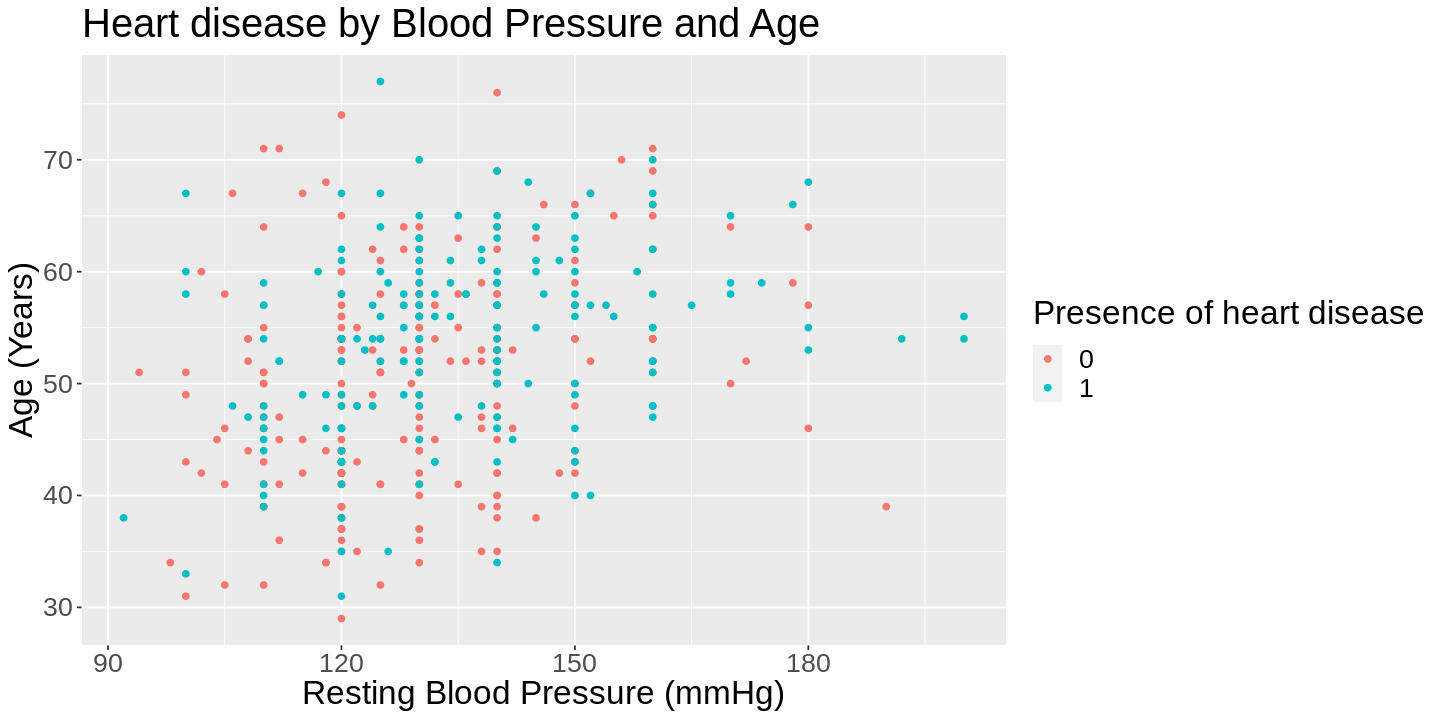

In [84]:
options(repr.plot.width = 12, repr.plot.height = 6)
heart_plot_chol_bps <- heart_train |>
                ggplot(aes(x = trestbps, y = age, color = num)) +
                geom_point() +
                theme(text = element_text(size = 20)) +
                labs (x = 'Resting Blood Pressure (mmHg)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Heart disease by Blood Pressure and Age")
heart_plot_chol_bps

This scatterplot shows the correlations between blood pressure (on the x axis) and age (on the y axis) to heart disease (the color of the points). Generally, it can be seen that as age and resting blood pressure increase, there is a higher presence of heart disease. This is a weak positive correlation.

##Expected Outcomes and Significance

Based on some preliminary research, we expect to find some relationship between heart disease and blood pressure (high blood pressure indicates an increase risk for heart disease diagnosis). Cholesterol and blood pressure are also linked, thus indicating that cholesterol levels could be related to heart disease diagnosis. Age has been linked to all three (higher age, increased risk for high blood pressure, high cholesterol and heart disease). We are testing to see if we can predict whether a patient has heart disease based purely off of these variables, which are cheap to test for.

The impact is clear: if we can diagnose heart disease used other indicators aside from an angiogram, it means less costly procedure for physicians and patients, leading to increased access to heart disease diagnosis.

Future questions may allow us to rethink current standard diagnosis practices in medicine and explore easier, less expensive options. If this project is successful, one possible question is *"What other variables can we use to successfully predict heart disease?" If it isn't, the question might be "